# 1. Import Modules

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
df_ticker = pd.read_csv("ticker.csv")
print(df_ticker.head())

                       Name    ID Ticker Exchange
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ
1               Kraft Heinz  2161    KHC   NASDAQ
2                  Fastenal  2316   FAST   NASDAQ
3                    Splunk   237   SPLK   NASDAQ
4                    Kroger  1813     KR     NYSE


In [41]:
df_ticker_description = pd.read_csv("ticker_description.csv")
print(df_ticker_description.head())

     Header                                        Description
0      Name                           The name of the company.
1        ID               A unique numeric ID for the company.
2    Ticker  The ticker symbol for the company's shares on ...
3  Exchange  The exchange on which the company's shares are...


In [42]:
df_core = pd.read_csv("core.csv")
print(df_core.head())

            Name   ID        Country                     Website  \
0  Accenture Plc  803        Ireland  https://www.accenture.com/   
1      Cognizant  806  United States   https://www.cognizant.com   
2         Amazon   23  United States           http://amazon.com   
3            IBM  115  United States         http://www.ibm.com/   
4      Microsoft  163  United States    http://www.microsoft.com   

                                       Groups         Region   Stage  \
0                                     S&P 500         Europe  Mature   
1                                     S&P 500  North America  Mature   
2                    S&P 500, Global Big Tech  North America  Mature   
3                    S&P 500, Global Big Tech  North America  Mature   
4  S&P 500, Global Big Tech, GenAI Contenders  North America  Mature   

                   Sector                                        Description  \
0  Software & IT Services  Accenture is a professional services company, ...  

In [43]:
df_core_description = pd.read_csv("core_description.csv")
print(df_core_description.head())

  Variable Name                                        Description
0          Name                 The canonical name of the company.
1            ID               A unique numeric ID for the company.
2       Country  The country where the company's headquarters i...
3       Website                            The company's homepage.
4        Groups          Thematic groups that include the company.


# 2. Example question
How does the number of AI-related patents or publications correlate with the scale of tech workforce

In [44]:
ai_metrics = ["AI_Publications", "AI_Growth", "Total_Publications", "AI patents", 
              "Patents_Growth", "Granted_AI_patents"]
workforce_metrics = ["Workforce_AI_workers", "Workforce_Tech_Team_Workers"]

In [45]:
df_ai_metrics = df_core[ai_metrics]
print(df_ai_metrics.head())

df_workforce_metrics = df_core[workforce_metrics]
print(df_workforce_metrics.head())

   AI_Publications  AI_Growth  Total_Publications  AI patents  Patents_Growth  \
0              208  36.476608                1197         489        2.042773   
1              209   5.529432                1191          77       14.880952   
2             3313  51.212094                9202        1819       19.322628   
3             7428   3.357918               30306        8724       21.137393   
4             9807  18.074120               25704        3728        6.434429   

   Granted_AI_patents  
0                 238  
1                  51  
2                1655  
3                6079  
4                1999  
   Workforce_AI_workers  Workforce_Tech_Team_Workers
0                 13610                       166212
1                  5226                       130530
2                 14164                       128591
3                  6114                       117521
4                  5245                       104414


We plot a correlation matrix between the selected variables

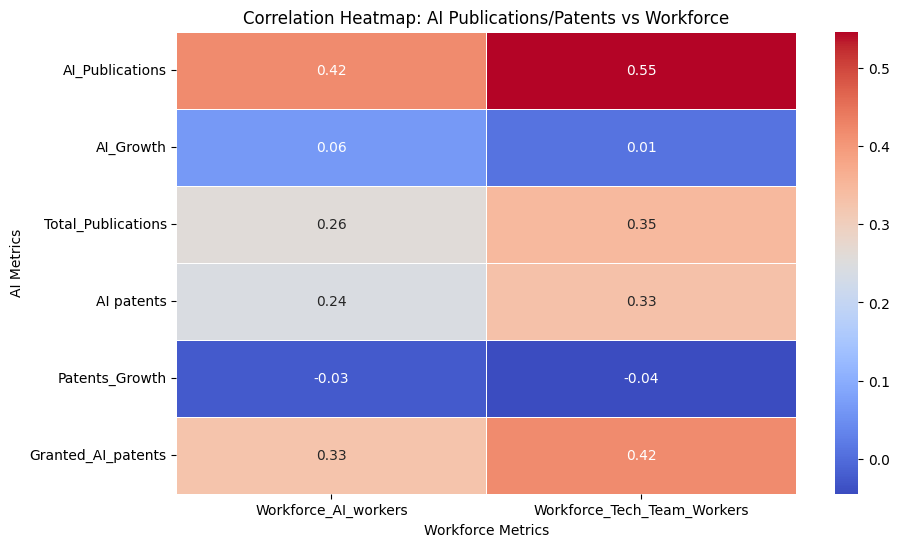

In [46]:
df_selected = df_core[ai_metrics + workforce_metrics].dropna()

# Compute correlation matrix
correlation_matrix = df_selected.corr()

# Extract correlation between AI metrics and workforce metrics
correlation_subset = correlation_matrix.loc[ai_metrics, workforce_metrics]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titles and labels
plt.title("Correlation Heatmap: AI Publications/Patents vs Workforce")
plt.xlabel("Workforce Metrics")
plt.ylabel("AI Metrics")

# Show plot
plt.show()

The number of AI_Publicationss, Total_Publiccations, AI patents, and Granted_AI_patents are positively correlated to Workforce_AI_woprkers and Workforce_Tech_Team_workers
